# Test Bandit - 2

Bounded time pure exploration v. ep-greedy

In [47]:
import shutil
import glob
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib.local_gym import BanditUniform4

from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic

from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import BoundedSequentialActor

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save
from explorationlib.score import total_reward

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# One bandit for all

In [49]:
# Experiment settings
# For all keep the maze the saame
num_experiments = 100
num_steps = 1000
seed_value = 499

# Env
env = BanditUniform4()
env.seed(seed_value)

[499]

## Compare
BoundedRand, BoundedSeq, Ep

In [54]:
bound = 8

# Agents
ran = BanditActorCritic(
    BoundedRandomActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# -
agents = [ran, seq, epy]
names = ["b-random", "b-sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

ep-greedy: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


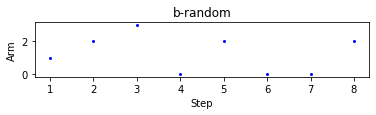

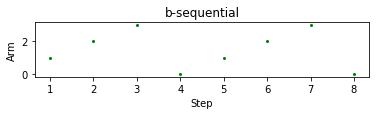

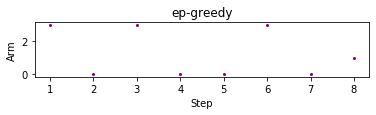

In [62]:
num_experiment = 4
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=bound,
        s=4,
        title=name, 
        color=color,
        figsize=(6,1)
        )

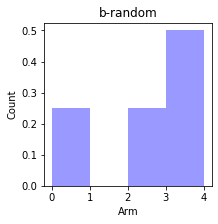

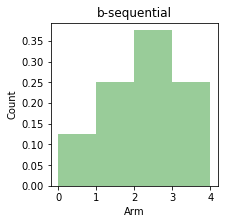

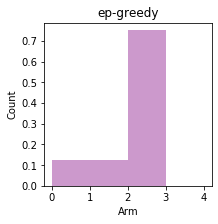

In [60]:
num_experiment = 93
ax = None
for name, res, color in zip(names, results, colors):
    plot_bandit_hist(
        select_exp(res, num_experiment), 
        bins=list(range(0, 5)),
        title=name, 
        max_steps=bound,
        alpha=0.4,
        color=color,
        figsize=(3, 3),
        ax=ax
        )

total_reward: 100%|██████████| 100/100 [00:00<00:00, 1691.57it/s]


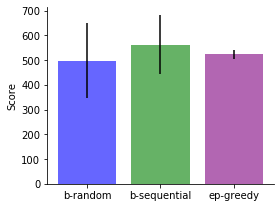

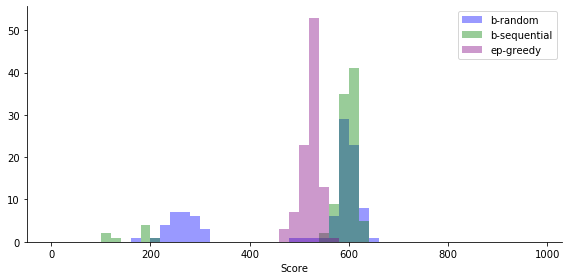

In [61]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 20)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()